In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px


In [44]:
# 生成Drink Dataset
np.random.seed(42)  # 設置隨機種子以便結果可重複

# 定義資料集結構
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
drinks = ['7Up', 'Sprite', 'Pepsi', 'Coke', 'Cappuccino', 'Espresso', 'Latte']
counts = [100, 200, 100, 400, 400, 200, 100]

data = {
    'Class': [],
    'Drink': [],
    'Rank': [],
    'Amount': [],
    'Quantity': []
}

for i, cls in enumerate(classes):
    count = counts[i]
    data['Class'] += [cls] * count
    data['Drink'] += [drinks[i]] * count
    data['Rank'] += [7 - i] * count  # 假設Rank從7到1
    data['Amount'] += list(np.random.normal((i + 1) * 100, 50, count))
    data['Quantity'] += list(np.random.randint(50 * (i + 1), 100 * (i + 1), count))

df = pd.DataFrame(data)

t-SNE在處理名目型屬性的兩種方法
1. one-of-k
2. similarity

In [45]:
# 處理名目型欄位Drink：1-of-k編碼
one_hot_encoder = OneHotEncoder()
encoded_drink_one_hot = one_hot_encoder.fit_transform(df[['Drink']]).toarray()

# 處理名目型欄位Drink：基於屬性值相似度的編碼
# 設定名目型屬性的相似度矩陣
drink_similarity = {
    '7Up': {'7Up': 0, 'Sprite': 1, 'Pepsi': 1, 'Coke': 1, 'Cappuccino': 3, 'Espresso': 3, 'Latte': 3},
    'Sprite': {'7Up': 1, 'Sprite': 0, 'Pepsi': 1, 'Coke': 1, 'Cappuccino': 3, 'Espresso': 3, 'Latte': 3},
    'Pepsi': {'7Up': 1, 'Sprite': 1, 'Pepsi': 0, 'Coke': 1, 'Cappuccino': 3, 'Espresso': 3, 'Latte': 3},
    'Coke': {'7Up': 1, 'Sprite': 1, 'Pepsi': 1, 'Coke': 0, 'Cappuccino': 3, 'Espresso': 3, 'Latte': 3},
    'Cappuccino': {'7Up': 3, 'Sprite': 3, 'Pepsi': 3, 'Coke': 3, 'Cappuccino': 0, 'Espresso': 1, 'Latte': 1},
    'Espresso': {'7Up': 3, 'Sprite': 3, 'Pepsi': 3, 'Coke': 3, 'Cappuccino': 1, 'Espresso': 0, 'Latte': 1},
    'Latte': {'7Up': 3, 'Sprite': 3, 'Pepsi': 3, 'Coke': 3, 'Cappuccino': 1, 'Espresso': 1, 'Latte': 0}
}

similarity_matrix = np.array([[drink_similarity[drink1][drink2] for drink2 in df['Drink']] for drink1 in df['Drink']])

# 標準化數值型欄位
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Rank', 'Amount', 'Quantity']])

# 合併特徵：1-of-k編碼
combined_features_one_hot = np.hstack((encoded_drink_one_hot, scaled_features))

# 合併特徵：基於屬性值相似度的編碼
combined_features_similarity = np.hstack((similarity_matrix, scaled_features))

# 使用t-SNE降維：1-of-k編碼
tsne = TSNE(n_components=2, random_state=42)
tsne_results_one_hot = tsne.fit_transform(combined_features_one_hot)

# 使用t-SNE降維：基於屬性值相似度的編碼
tsne_results_similarity = tsne.fit_transform(combined_features_similarity)

# 將t-SNE結果加入資料集
df['tSNE-1-one-hot'] = tsne_results_one_hot[:, 0]
df['tSNE-2-one-hot'] = tsne_results_one_hot[:, 1]
df['tSNE-1-similarity'] = tsne_results_similarity[:, 0]
df['tSNE-2-similarity'] = tsne_results_similarity[:, 1]


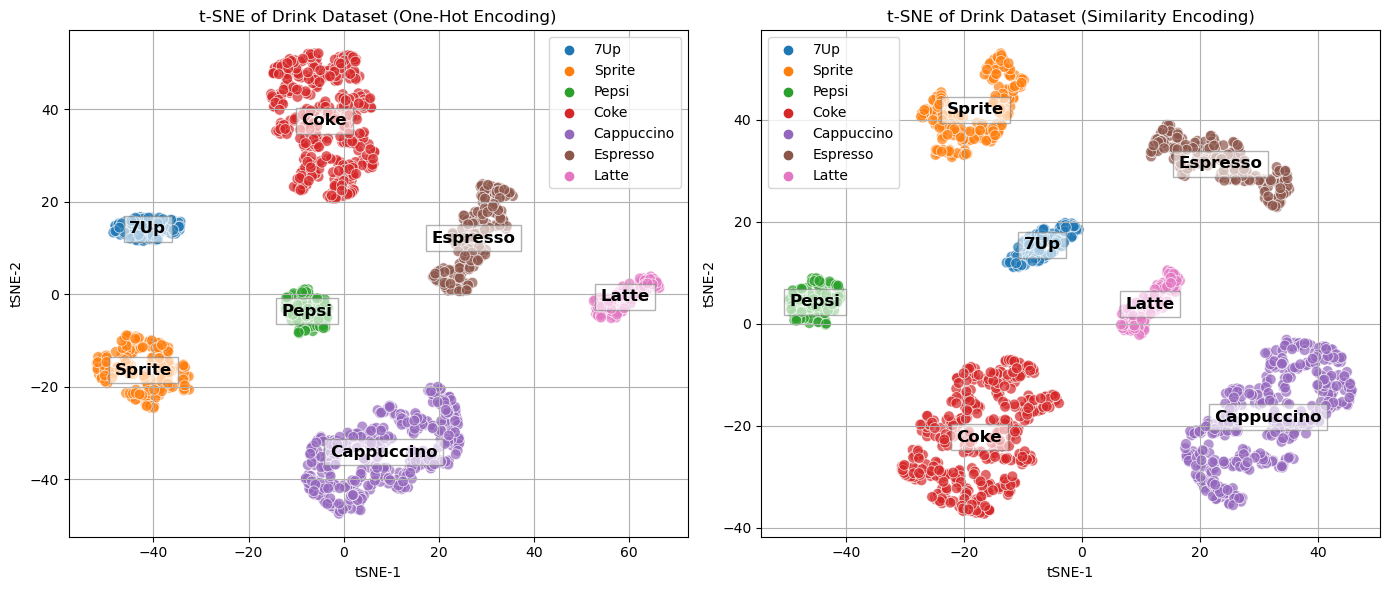

In [46]:
# 計算每個群集的中心點
cluster_centers_one_hot = df.groupby('Drink')[['tSNE-1-one-hot', 'tSNE-2-one-hot']].mean()
cluster_centers_similarity = df.groupby('Drink')[['tSNE-1-similarity', 'tSNE-2-similarity']].mean()

# 繪製2D結果並標註中心點：1-of-k編碼
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='tSNE-1-one-hot', y='tSNE-2-one-hot', hue='Drink', data=df, palette='tab10', s=60, alpha=0.7)
for class_label, (x, y) in cluster_centers_one_hot.iterrows():
    plt.text(x, y, class_label, fontsize=12, weight='bold', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
plt.title('t-SNE of Drink Dataset (One-Hot Encoding)')
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.legend(loc='best')
plt.grid(True)

# 繪製2D結果並標註中心點：基於屬性值相似度的編碼
plt.subplot(1, 2, 2)
sns.scatterplot(x='tSNE-1-similarity', y='tSNE-2-similarity', hue='Drink', data=df, palette='tab10', s=60, alpha=0.7)
for class_label, (x, y) in cluster_centers_similarity.iterrows():
    plt.text(x, y, class_label, fontsize=12, weight='bold', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
plt.title('t-SNE of Drink Dataset (Similarity Encoding)')
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()


In [47]:
# 創建Dash應用
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# 計算每個類別的中心點並添加標籤
def add_class_labels(fig, df, x_col, y_col):
    class_centers = df.groupby('Class')[[x_col, y_col]].mean()
    class_drinks = df.groupby('Class')['Drink'].first()

    for class_label, (x, y) in class_centers.iterrows():
        drink_name = class_drinks[class_label]
        fig.add_annotation(
            x=x, y=y, text=f'{class_label}: {drink_name}', showarrow=False, yshift=10
        )

fig_one_hot = px.scatter(df, x='tSNE-1-one-hot', y='tSNE-2-one-hot', color='Class', hover_data=['Class', 'Drink', 'Rank', 'Amount', 'Quantity'])
add_class_labels(fig_one_hot, df, 'tSNE-1-one-hot', 'tSNE-2-one-hot')

fig_similarity = px.scatter(df, x='tSNE-1-similarity', y='tSNE-2-similarity', color='Class', hover_data=['Class', 'Drink', 'Rank', 'Amount', 'Quantity'])
add_class_labels(fig_similarity, df, 'tSNE-1-similarity', 'tSNE-2-similarity')

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='scatter-plot-one-hot', figure=fig_one_hot)
        ], width=6),
        dbc.Col([
            dcc.Graph(id='scatter-plot-similarity', figure=fig_similarity)
        ], width=6)
    ]),
    dbc.Row([
        dbc.Col([
            html.Div(id='selected-data-one-hot')
        ], width=6),
        dbc.Col([
            html.Div(id='selected-data-similarity')
        ], width=6)
    ])
])

@app.callback(
    Output('selected-data-one-hot', 'children'),
    [Input('scatter-plot-one-hot', 'selectedData')]
)
def display_selected_data_one_hot(selectedData):
    if selectedData is None:
        return "No data selected"

    points = selectedData['points']
    selected_points = []
    for point in points:
        selected_points.append(point['customdata'])

    selected_df = pd.DataFrame(selected_points, columns=['Class', 'Drink', 'Rank', 'Amount', 'Quantity'])
    return dbc.Table.from_dataframe(selected_df, striped=True, bordered=True, hover=True)

@app.callback(
    Output('selected-data-similarity', 'children'),
    [Input('scatter-plot-similarity', 'selectedData')]
)
def display_selected_data_similarity(selectedData):
    if selectedData is None:
        return "No data selected"

    points = selectedData['points']
    selected_points = []
    for point in points:
        selected_points.append(point['customdata'])

    selected_df = pd.DataFrame(selected_points, columns=['Class', 'Drink', 'Rank', 'Amount', 'Quantity'])
    return dbc.Table.from_dataframe(selected_df, striped=True, bordered=True, hover=True)


if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

c:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



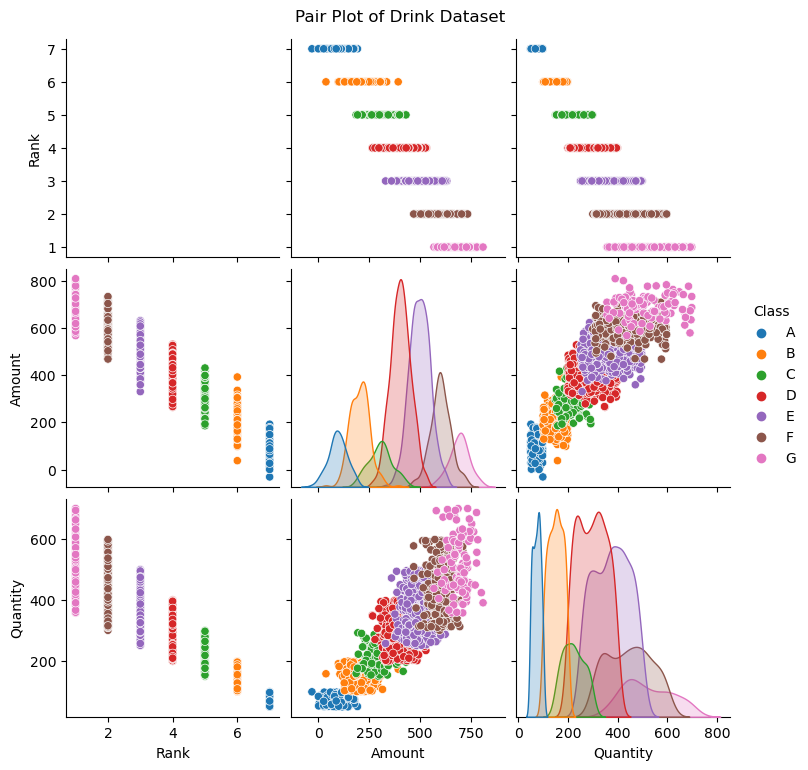

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# 繪製散佈圖矩陣
sns.pairplot(df, hue='Class', vars=['Rank', 'Amount', 'Quantity'])
plt.suptitle('Pair Plot of Drink Dataset', y=1.02)
plt.show()
